<a href="https://colab.research.google.com/github/vanderbilt-ml/51-callahan-mlproj-realestate/blob/updating-encoding/real_estate_project_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real Estate Prediction and Market Intelligence

## Background
Real estate has many opportunities in which to apply data science methods.  I want to develop a model that will allow for identification of pricing assymetries in the real estate market by being able to accurately price assets and there by identify opportunities when new properties are discovered. 

## Project Description
My goal is to develop a model that can detect "good prices" in real estate markets of my choosing in order to identify deals.  Maybe I will buy one of these properties someday!

## Performance Metric + Analyses
1. *Pricing Accuracy* - can the model learn what a good price is and make a price prediction for a specific property?  This would involve predicting the price at which a property will sell based on a variety of features, and can be verified in training data by comparing the prediction with the actual sale price.  RMSE comes to mind as a possible measure of model accuracy. 

2. *Value Drivers* - which attributions associated with a property influence price and do those factors change based on geography?  Obvious things like square-foot (size) of property will matter, but there are likely other discoverable features here that provide a rich opportunity for feature engineering.  Normalizing for macro-economic trends may also be an option, since housing prices are defined inside a marketplace that is influenced by factors like: mortgage rates, inflation, GDP, etc... 

3. *Similar markets* - Which markets are complementary in the sense that they have similar attributes and properties represent a similar value to purchasers?  Identifying a similarity metric for markets would allow this analysis to encompass greater quantities of data.  Presumably, data from similar markets could be combined to make predictions while dissimilar ones should be excluded.  As an example, California beachfront property or NYC apartments are likely not comparable to a single family home in the midwest and we would not want to train data using Cali/NYC data if we want to predict home prices in rural Kansas.

## Historical Model Performance

### "Distance to Water" and "Nearest Body of Water" features added

**Overview**

Distance to water and nearest body of water are likely to be important features because real estate purchasers probably care about this.  Having a way to identify how close a property is to water and which water feature required incorporating GeoPandas into the analysis. The result is two new features.  First, distance_to_water, measures the distance to the nearest water feature in meters.  Second, water_feature, is the name of the nearest water feature that is at least 500 hectares.

**Performance**

RFR (R2 increase but decrease in model peformance)
1. R2: 0.7475745662533361
2. RMSE: 212516.48609785954
3. MAPE: 0.4530402382954198

LR (got worse)
1. R2: 0.14241231987245884
2. RMSE: 391710.61210430035
3. MAPE: 0.6911585464378046

GBD (big improvement)
1. R2: 0.7148021563811113
2. RMSE: 225891.13601564406
3. MAPE: 0.45884098463405043

### Initial Model 

**Overview**

Features 1-6, with optimizations made to reduce the impact of high cardinality columns as well as expand dates and perform unit conversions.

**Performance**

RFR
1. R2: 0.6799018647159624
2. RMSE: 200475.45049726398
3. MAPE: 0.42061022659688296

LR
1. R2: 0.3044845434643467
2. RMSE: 295510.56951387296
3. MAPE: 0.6564594704859447

GBD
1. R2: 0.48669563308526864
2. RMSE: 253867.4995511361
3. MAPE: 0.5071241646448831

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ast import literal_eval

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

sns.set_theme(rc={
    'figure.autolayout':True,
    'figure.subplot.wspace':0.02}
    )

In [4]:
eda = pd.read_csv('https://raw.githubusercontent.com/vanderbilt-ml/51-callahan-mlproj-realestate/main/northern_MI_market_total_2022-05-22_sold.csv',
                  parse_dates=['last_update', 'sold_date'],
                  infer_datetime_format=True)

eda['address_new'] = eda['address_new'].apply(literal_eval)

In [5]:
eda.head(2)

,property_id,prop_type,last_update,address,address_new,prop_status,price_raw,sqft_raw,is_showcase,is_new_construction,price,beds,baths,sqft,lot_size,photo,short_price,baths_half,baths_full,photo_count,sold_date,lat,lon,has_leadform,page_no,rank,list_tracking,listing_id,list_date,advertiser_id,agent_name,agent_photo,office_name,office_advertiser_id,price_reduced,products,price_reduced_date,is_cobroker,is_foreclosure,snapshot_date
0,9736410692,condo,2022-05-16 19:13:28+00:00,"841 Fern St Apt 4, Traverse City, 49686","{'line': '841 Fern St Apt 4', 'street_number':...",recently_sold,160000,545.0,False,False,"$160,000",1.0,1,545 sq ft,NaN,https://ap.rdcpix.com/2d7056dea24011b9d144d742...,$160K,NaN,1.0,22.0,2022-05-16,44.751955,-85.59743,False,4,31,type|property|data|prop_id|9736410692|list_id|...,2.942730e+09,2022-05-04T18:01:57Z,1285943.0,Matt Geib,https://p.rdcpix.com/v05/a379f1300-c0od-r7_w11...,CENTURY 21 Northland,558238.0,False,"['core.agent', 'core.broker', 'co_broke']",NaN,True,NaN,5/22/22
1,9863486331,condo,2022-02-28 17:56:49+00:00,"841 Fern St Apt 1, Traverse City, 49686","{'line': '841 Fern St Apt 1', 'street_number':...",recently_sold,209900,775.0,False,False,"$209,900",2.0,1,775 sq ft,NaN,https://ap.rdcpix.com/7f30757aa101576f09b5bcad...,$209K,NaN,1.0,26.0,2022-02-28,44.751955,-85.59743,False,5,36,type|property|data|prop_id|9863486331|list_id|...,2.938909e+09,2022-01-12T20:17:22Z,1285943.0,Matt Geib,https://p.rdcpix.com/v05/a379f1300-c0od-r7_w11...,CENTURY 21 Northland,558238.0,False,"['core.agent', 'core.broker', 'co_broke']",NaN,True,NaN,5/22/22


In [6]:
# 944 entries, 141 land (vacant lots) as well as other/commercial and farm can all be dropped.  These are non-residential properties and not the focus of this analysis. 
# 789 values remain in dataset. 

display(eda.shape[0])
display(eda['prop_type'].value_counts())

prop_data = eda[ eda['prop_type'].isin(['single_family', 'condo', 'multi_family', 'mobile']) ]

display(prop_data.shape[0])
display(prop_data['prop_type'].value_counts())

944

single_family    475
condo            286
land             141
mobile            20
other             10
multi_family       8
commercial         3
farm               1
Name: prop_type, dtype: int64

789

single_family    475
condo            286
mobile            20
multi_family       8
Name: prop_type, dtype: int64

## Data Cleaning

In [7]:
prop_data['last_update'] = pd.to_datetime(prop_data['last_update'], utc=True).dt.date
prop_data['list_date'] = pd.to_datetime(prop_data['list_date'], utc=True).dt.date
prop_data['price_reduced_date'] = pd.to_datetime(prop_data['price_reduced_date'], utc=True).dt.date

prop_data = prop_data[ prop_data['prop_type'].isin(['single_family', 'condo', 'multi_family']) ]
# prop_data = prop_data.loc['single_family', 'condo', 'multi_family']

prop_data = prop_data.dropna(subset=['sqft_raw'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [8]:
prop_data['prop_type'].value_counts()

single_family    413
condo            228
multi_family       8
Name: prop_type, dtype: int64

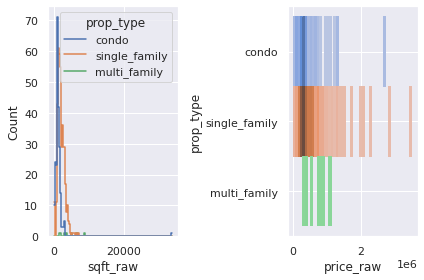

In [9]:
fig, ax = plt.subplots(1,2)

sns.histplot(
    data=prop_data, 
    x="sqft_raw", 
    hue='prop_type', 
    kde=False, 
    element='step', 
    fill=False,
    ax=ax[0]
)

sns.histplot(
    prop_data, 
    x="price_raw", 
    y="prop_type", 
    hue="prop_type", 
    legend=False,
    ax=ax[1]
)

fig.show()

# Feature Engineering

## Feature 1 - Address Details

In [11]:
# Example JSON object
{'line': '4439 Ironwood Dr N', 
 'street_number': '4439', 
 'street': 'Ironwood', 
 'street_suffix': 'Dr', 
 'unit': None, 
 'city': 'Traverse City', 
 'state': 'Michigan', 
 'state_code': 'MI', 
 'postal_code': '49685', 
 'lat': 44.645801, 
 'long': -85.66523, 
 'county': 'Grand Traverse'}

{'city': 'Traverse City',
 'county': 'Grand Traverse',
 'lat': 44.645801,
 'line': '4439 Ironwood Dr N',
 'long': -85.66523,
 'postal_code': '49685',
 'state': 'Michigan',
 'state_code': 'MI',
 'street': 'Ironwood',
 'street_number': '4439',
 'street_suffix': 'Dr',
 'unit': None}

In [12]:
unpacked_address = prop_data['address_new'].apply(pd.Series).drop(columns=['lat', 'long', 'street_number', 'street_suffix', 'unit', 'line', 'street'])

display(unpacked_address)

prop_data = pd.concat([prop_data, unpacked_address], 
              axis=1)


,city,state,state_code,postal_code,county
0,Traverse City,Michigan,MI,49686,Grand Traverse
1,Traverse City,Michigan,MI,49686,Grand Traverse
2,Traverse City,Michigan,MI,49696,Grand Traverse
3,Traverse City,Michigan,MI,49684,Grand Traverse
4,Traverse City,Michigan,MI,49686,Grand Traverse
...,...,...,...,...,...
933,Harbor Springs,Michigan,MI,49740,Emmet
934,Harbor Springs,Michigan,MI,49740,Emmet
938,Harbor Springs,Michigan,MI,49740,Emmet
941,Harbor Springs,Michigan,MI,49740,Emmet


## Feature 2 - Bathrooms 

In [13]:
prop_data['baths'] = prop_data['baths'].replace('Call', np.NaN)
prop_data['bath'] = prop_data['baths_half'].fillna(0) / 2 + prop_data['baths_full'].fillna(0)

# No bathrooms? No way.  Make these NAN and fill during pipelines later
prop_data['bath'] = prop_data['bath'].replace(0, np.NaN)


## Feature 3 - Align binary values across variable types

In [14]:
binary_cols = ['is_showcase', 'is_new_construction', 'has_leadform', 'is_cobroker', 'is_foreclosure', 'price_reduced']

prop_data[binary_cols] = prop_data[binary_cols].fillna(False)

for col in binary_cols:
    print(col)
    display(prop_data[col].value_counts(dropna=False))

is_showcase


False    649
Name: is_showcase, dtype: int64

is_new_construction


False    590
True      59
Name: is_new_construction, dtype: int64

has_leadform


False    649
Name: has_leadform, dtype: int64

is_cobroker


True     395
False    254
Name: is_cobroker, dtype: int64

is_foreclosure


False    647
True       2
Name: is_foreclosure, dtype: int64

price_reduced


False    566
True      83
Name: price_reduced, dtype: int64

## Feature 4 - Unit Conversions


In [15]:
# Extract lot sizes, convert to same units

def acres_to_sqft(row):
    if 'acres' in str(row['lot_size']):
        return float(str.strip(row['lot_size'].replace('acres', '').replace(',', ''))) * 43560
    elif 'sq ft lot' in str(row['lot_size']):
        return float(str.strip(row['lot_size'].replace('sq ft lot', '').replace(',', '')))
    elif pd.isna(row['lot_size']):
        return row['lot_size']   
    else:
        return -1   

prop_data['lot_size_sqft'] = prop_data.apply(acres_to_sqft, axis=1)

display(f"Unclassified Values: {prop_data[ prop_data['lot_size_sqft'] == -1].shape[0]}")

'Unclassified Values: 0'

## Feature 5 - Days on Market + Days at Reduced Price


In [16]:
prop_data['dom'] = (prop_data['sold_date'].dt.date - prop_data['list_date']).dt.days

prop_data['drp'] = np.where(pd.isna(prop_data['price_reduced_date']),
                                    np.NaN,
                                    (prop_data['sold_date'].dt.date  - prop_data['price_reduced_date']).dt.days)




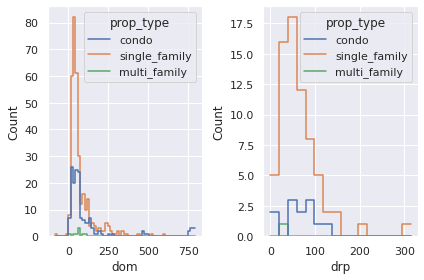

In [17]:


fig, ax = plt.subplots(1,2)

sns.histplot(
    data=prop_data, 
    x="dom", 
    hue='prop_type', 
    kde=False, 
    element='step', 
    fill=False,
    ax=ax[0]
)

sns.histplot(
    data=prop_data, 
    x="drp", 
    hue='prop_type', 
    kde=False, 
    element='step', 
    fill=False,
    ax=ax[1]
)

fig.show()

## Feature 6 - Date Unpacking

In [18]:
prop_data = prop_data.assign(sold_year = prop_data['sold_date'].dt.year, 
                 sold_quarter = prop_data['sold_date'].dt.quarter,
                 sold_month = prop_data['sold_date'].dt.month,
                 sold_week = prop_data['sold_date'].dt.isocalendar().week,
                 sold_day = prop_data['sold_date'].dt.day)

## Feature 7 - Distance to Water

In [25]:
!pip install geopandas

import geopy.distance
import geopandas as gpd

from shapely.geometry import Point

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 6.5 MB/s 
     |████████████████████████████████| 16.7 MB 302 kB/s 
     |████████████████████████████████| 6.3 MB 48.8 MB/s 


In [28]:
oceans = gpd.read_file("https://raw.githubusercontent.com/vanderbilt-ml/51-callahan-mlproj-realestate/715f5ddc6512bda9f1884e2516b63ebfda5fbc05/ne_10m_lakes.zip")
oceans = oceans.dropna(subset=['name_en'])
oceans = oceans[ oceans['name_en'].str.contains('Michigan|Huron') ]

# https://gis-michigan.opendata.arcgis.com/datasets/lake-polygons/explore?location=44.632311%2C-85.507423%2C7.31
lakes = gpd.read_file('https://raw.githubusercontent.com/vanderbilt-ml/51-callahan-mlproj-realestate/715f5ddc6512bda9f1884e2516b63ebfda5fbc05/MI_lakes_at_least_500_hectares.zip')


In [29]:
# Minimum size body of water to count as a "lake"
lakes = lakes[ lakes['HECTARES'] >= 500]

lakes = lakes[['geometry', 'NAME']]
oceans = oceans[['geometry', 'name']]

# Combine polygon data
lakes = lakes.append(oceans)

# Coalesce names and set index
lakes['NAME'].fillna(lakes['name'], inplace=True)
lakes['NAME'].fillna('unknown', inplace=True)

lakes = lakes.set_index('NAME').drop(columns=['name'])

In [31]:
# https://sciencing.com/convert-latitude-longtitude-feet-2724.html
# https://stackoverflow.com/questions/30740046/calculate-distance-to-nearest-feature-with-geopandas

def min_distance(point, lines):
    if 'nan' in str(point):
        return (-1, 'NA')
    
    return (lines.distance(point).min() * 111139.0, lines.distance(point).idxmin()) 

prop_data_geo['dist_to_water_meters'], \
prop_data_geo['nearest_water_feature'] = zip(*prop_data_geo['geometry'].apply(min_distance, 
                                                                                  args=(lakes['geometry'],)))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


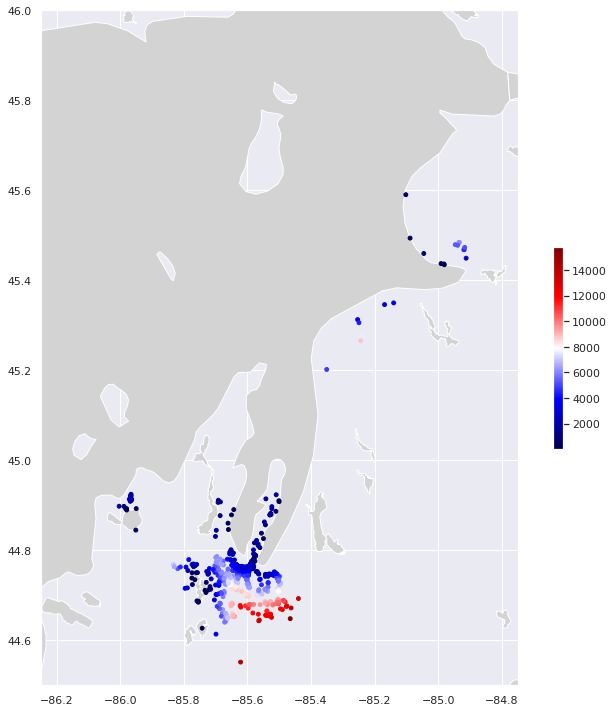

In [32]:
minx, maxx = -86.25, -84.75
miny, maxy = 44.5, 46

fig,ax = plt.subplots(figsize = (10,10))

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(prop_data['lon'], prop_data['lat'])]

prop_data_geo = gpd.GeoDataFrame(prop_data, 
                                    crs=crs,
                                    geometry=geometry)

lakes.plot(ax=ax, color='lightgrey')

prop_data_geo[prop_data_geo['dist_to_water_meters'] > 0].plot(ax=ax, 
                           column='dist_to_water_meters', 
                           cmap = 'seismic', 
                           legend=True, 
                           legend_kwds={'shrink': 0.3},
                           markersize = 15)

## Remove unusable variables

Last update > Sold date means a listing was changed after sale, which seems like a bad value to use in sale prediction

In [39]:
prop_data[ prop_data['last_update'] > prop_data['sold_date'] ].shape

(469, 57)

In [43]:
drop_columns = ['address', 'address_new', 'prop_status', 'price', 'sqft', 'photo', 'short_price', 'products',
              'photo_count', 'page_no', 'rank', 'list_tracking', 'listing_id', 'property_id', 
              'advertiser_id', 'agent_photo', 'office_name', 'office_advertiser_id', 'snapshot_date', 'agent_name',
              'last_update']


clean_drop = ['lot_size', 'baths', 'baths_full', 'baths_half', 'price_reduced', 'price_reduced_date', 'list_date', 'sold_date', 'geometry']


In [44]:
prop_data_input = prop_data_geo.drop(columns=drop_columns + clean_drop)

In [47]:
prop_data_input.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 649 entries, 0 to 942
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   prop_type              649 non-null    object 
 1   price_raw              649 non-null    int64  
 2   sqft_raw               649 non-null    float64
 3   is_showcase            649 non-null    bool   
 4   is_new_construction    649 non-null    bool   
 5   beds                   577 non-null    float64
 6   lat                    649 non-null    float64
 7   lon                    649 non-null    float64
 8   has_leadform           649 non-null    bool   
 9   is_cobroker            649 non-null    bool   
 10  is_foreclosure         649 non-null    bool   
 11  city                   649 non-null    object 
 12  state                  649 non-null    object 
 13  state_code             649 non-null    object 
 14  postal_code            649 non-null    object 
 15

# Prepare Model

In [61]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.inspection import permutation_importance

show_importances = False

# https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html#sphx-glr-auto-examples-linear-model-plot-poisson-regression-non-normal-loss-py

In [50]:
X_train, X_test, y_train, y_test = train_test_split(prop_data_input.drop(columns='price_raw'), 
                                                    prop_data_input['price_raw'],
                                                    test_size=0.2, 
                                                    random_state=1234, 
                                                    stratify=prop_data_input['prop_type'])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(handle_unknown='ignore', 
                                                            drop='if_binary')
                               )])

num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(strategy='mean')),
                               ('scale_num', StandardScaler())])

preproc = ColumnTransformer([('cat_pipe', cat_pipeline, cat_cols),
                             ('num_pipe', num_pipeline, num_cols)],
                             remainder='passthrough')


(519, 26) (130, 26) (519,) (130,)


# Random Forest Regressor

In [51]:
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', RandomForestRegressor())
                       ])

# visualization of the pipeline
with config_context(display='diagram'):
    display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['prop_type', 'is_showcase',
                                                   'is_new_construction',
                                                   'has_leadform',
                                                   'is_cobroker',
                                                   'is_foreclosure', 'city',
                                                   'state', 'state_code',
                                                   'postal_code', 'county',
                                                   'nearest_water_feature']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  ['sqft_raw', 'beds', 'lat',
                                                   'lon', 'bath',
                                                   'lot_size_sqft', 'dom',
                                                   'drp', 'sold_year',
                                                   'sold_quarter', 'sold_month',
                                                   'sold_week', 'sold_day',
                                                   'dist_to_water_meters'])])),
                ('mdl', RandomForestRegressor())])

In [52]:
tuning_grid = {'mdl__n_estimators' : [100, 300, 500],
               'mdl__max_features': [0.3, 0.5, 0.7, 1.0] }

grid_search = GridSearchCV(pipe, 
                           param_grid = tuning_grid, 
                           cv = 5, 
                           return_train_score=True)

In [53]:
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in co

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['prop_type',
                                                                          'is_sh

### Performance

In [54]:
rmse = np.sqrt(mean_squared_error(y_test.reset_index(drop=True), grid_search.best_estimator_.predict(X_test)))
mape = mean_absolute_percentage_error(y_test.reset_index(drop=True), grid_search.best_estimator_.predict(X_test))
r2 = r2_score(y_test.reset_index(drop=True), grid_search.best_estimator_.predict(X_test))

print(f'R2: {r2}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

R2: 0.7475745662533361
RMSE: 212516.48609785954
MAPE: 0.4530402382954198


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['prop_type', 'is_showcase',
                                                   'is_new_construction',
                                                   'has_leadform',
                                                   'is_cobroker',
                                                   'is_foreclosure', 'city',
       

In [ ]:
if show_importances:

    scoring = ['r2', 
              'neg_root_mean_squared_error',
              'neg_mean_absolute_percentage_error']

    multi_r = permutation_importance(grid_search.best_estimator_, 
                              X_test, 
                              y_test,
                              n_repeats=30,
                              random_state=0, 
                              scoring=scoring)

In [ ]:
if show_importances:

    feature_names = pd.Series(X_test.columns)

    cat_names = list(grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names_out())
    num_names = list(grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2])

    # https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
    # fe is measured using the values from the scoring variable
    fe_vals = []

    # ordered from largest to smallest FE
    for metric in multi_r:
      r = multi_r[metric]
      for i in r.importances_mean.argsort()[::-1]:
          if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
              fe_vals.append((metric, feature_names[i], r.importances_mean[i], r.importances_std[i]))


    coef_info = pd.DataFrame(fe_vals, columns=['metric', 'feat_names', 'vip', 'sd'])

    coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                                coef_sign = np.sign(coef_info['vip']))
    

In [ ]:
#coef_info.head(3)

,metric,feat_names,vip,sd,coef_mag,coef_sign
0,r2,sqft_raw,0.377470,0.036709,0.377470,1.0
1,r2,lot_size_sqft,0.200655,0.030872,0.200655,1.0
2,r2,bath,0.083486,0.021158,0.083486,1.0


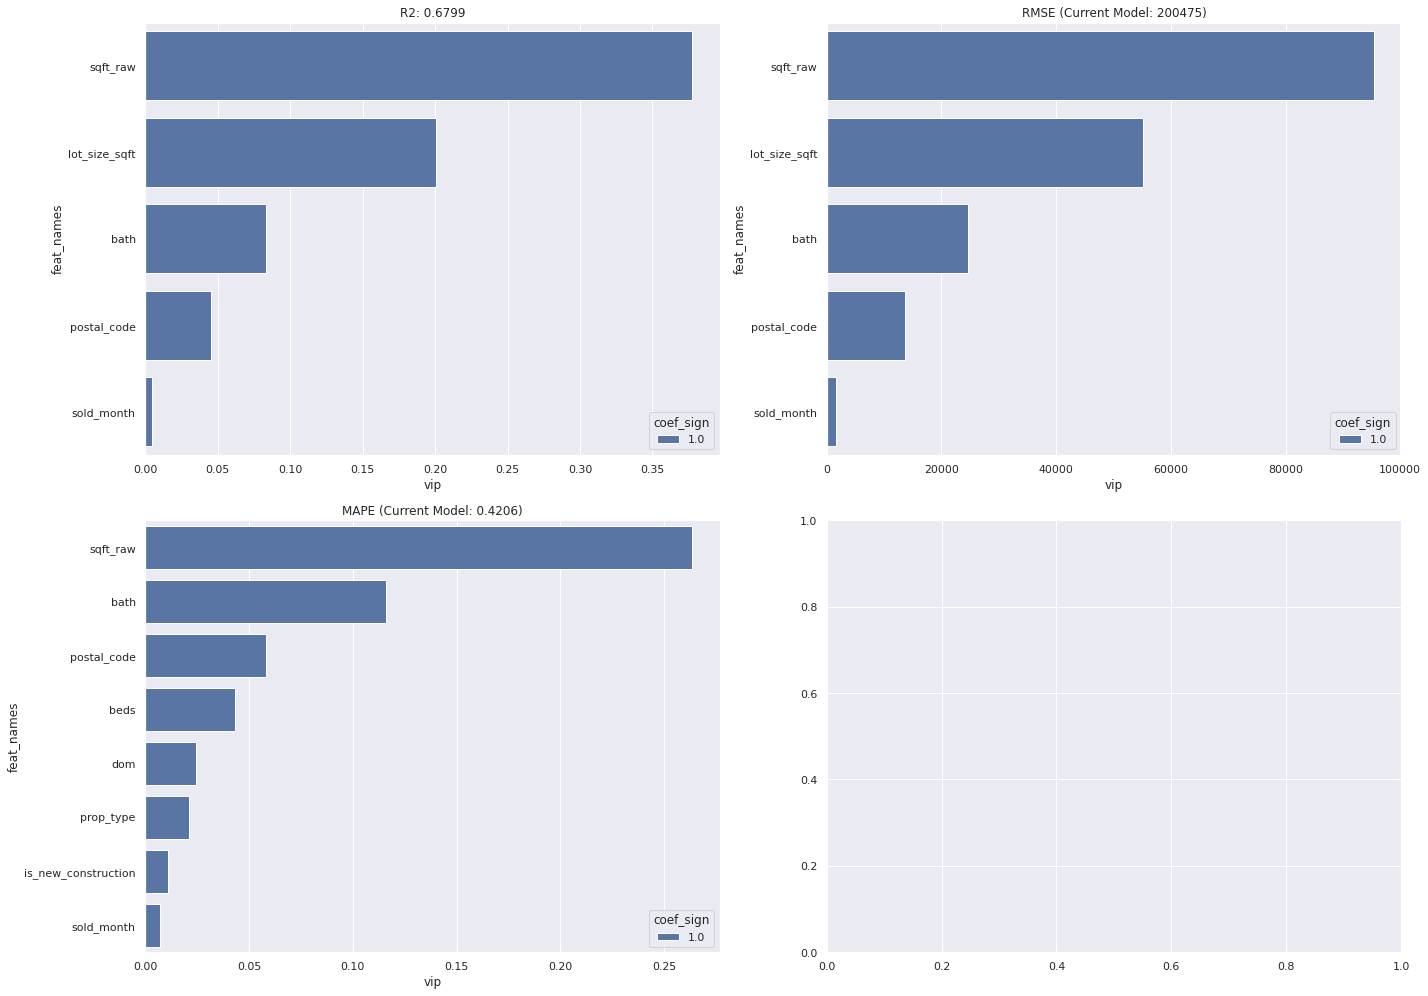

In [ ]:
if show_importances:
    # The permutation feature importance is the decrease in a model score when a single feature value is randomly shuffled

    fig, ax = plt.subplots(2,2)

    sns.barplot(
        data=coef_info[ coef_info['metric'] == 'r2'], 
        x="vip", 
        y='feat_names',
        hue='coef_sign', 
        ax=ax[0,0]
    ).set_title(f'R2: {r2:.4f}')

    sns.barplot(
        data=coef_info[ coef_info['metric'] == 'neg_root_mean_squared_error'], 
        x="vip", 
        y='feat_names',
        hue="coef_sign", 
        ax=ax[0,1]
    ).set_title(f'RMSE (Current Model: {rmse:.0f})')

    sns.barplot(
        data=coef_info[ coef_info['metric'] == 'neg_mean_absolute_percentage_error'], 
        x="vip", 
        y='feat_names',
        hue="coef_sign", 
        ax=ax[1,0]
    ).set_title(f'MAPE (Current Model: {mape:.4f})')

    fig.set_size_inches(20, 14)
    fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


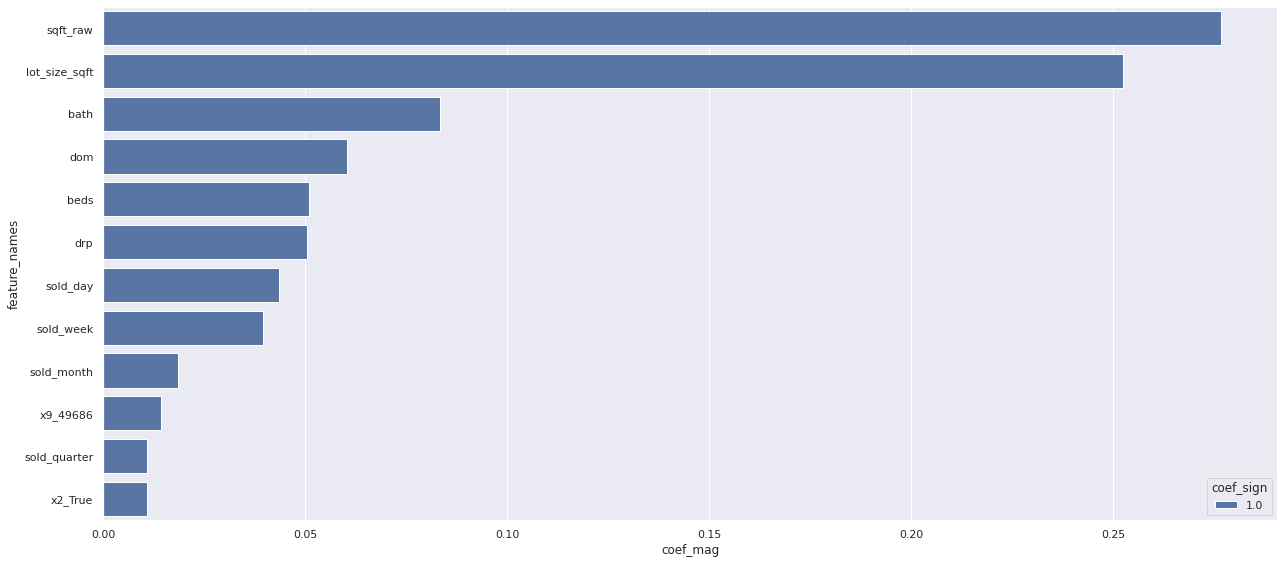

In [ ]:
if show_importances:
    coefs = grid_search.best_estimator_.named_steps['mdl'].feature_importances_

    cat_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
    num_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]

    # score coefficients into a new dataframe
    coef_info = pd.DataFrame({'feature_names': np.hstack([cat_names, num_names]), 'feature_imp': coefs})
    coef_info = coef_info[ coef_info['feature_imp'] > 0.01 ]

    # get sign and magnitude of the weights (coefs)
    coef_info = coef_info.assign(coef_mag = abs(coef_info['feature_imp']),
                                coef_sign = np.sign(coef_info['feature_imp']))

    # sort the coef_info dataframe and plot with a barplot! 
    coef_info = coef_info.set_index('feature_names').sort_values(by='coef_mag', ascending=False)
    sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False);

In [55]:
predictions = pd.concat([y_test.reset_index(), pd.Series(grid_search.best_estimator_.predict(X_test))], 
                        axis=1).set_index('index').rename(columns={0:'predicted_price'})

predictions['error'] = round(predictions['predicted_price'] - predictions['price_raw'], -3)
predictions['error_sign'] = np.sign(predictions['error'])
predictions['error'] = abs(predictions['error'])
predictions['perc_error'] = predictions['error'] / predictions['price_raw']

eval_frame = pd.concat([X_test, predictions], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


In [56]:
eval_frame.groupby(['prop_type']).agg({'error': np.mean,
                                       'price_raw':[np.mean, min, max, np.std]})

error      price_raw                                
                        mean           mean     min      max            std
prop_type                                                                  
condo           94956.521739  524250.108696   24000  2700000  544686.978834
multi_family   263000.000000  390000.000000  390000   390000            NaN
single_family  158746.987952  494513.795181   55000  2100000  346922.740103

### 10 Worst Predictions

In [ ]:
eval_frame.sort_values(by='perc_error', ascending=False).head(10)

,prop_type,sqft_raw,is_showcase,is_new_construction,beds,has_leadform,is_cobroker,is_foreclosure,city,state,state_code,postal_code,county,bath,lot_size_sqft,dom,drp,sold_year,sold_quarter,sold_month,sold_week,sold_day,price_raw,predicted_price,error,error_sign,perc_error
13,condo,1420.0,False,False,NaN,False,False,False,Traverse City,Michigan,MI,49686,Grand Traverse,NaN,13068.0,NaN,NaN,2021,4,12,48,3,30000,183871.576667,154000.0,1.0,5.133333
83,condo,1005.0,False,False,2.0,False,True,False,Traverse City,Michigan,MI,49686,Grand Traverse,2.0,NaN,46.0,NaN,2022,1,1,4,24,90000,305495.110000,215000.0,1.0,2.388889
169,single_family,1815.0,False,False,3.0,False,True,False,Traverse City,Michigan,MI,49685,Grand Traverse,2.0,106722.0,159.0,131.0,2021,4,12,50,14,175000,558980.710000,384000.0,1.0,2.194286
814,condo,1550.0,False,False,3.0,False,True,False,Glen Arbor,Michigan,MI,49636,Leelanau,2.5,NaN,39.0,NaN,2022,1,1,4,24,109900,327658.100000,218000.0,1.0,1.983621
131,condo,563.0,False,False,1.0,False,True,False,Traverse City,Michigan,MI,49684,Grand Traverse,1.0,NaN,51.0,NaN,2022,1,2,8,23,125000,355967.700000,231000.0,1.0,1.848000
160,condo,475.0,False,False,1.0,False,False,False,Traverse City,Michigan,MI,49684,Grand Traverse,1.0,NaN,50.0,NaN,2022,1,2,7,15,163000,427613.290000,265000.0,1.0,1.625767
137,single_family,726.0,False,False,1.0,False,True,False,Traverse City,Michigan,MI,49684,Leelanau,1.0,4356.0,101.0,NaN,2022,1,2,7,18,130000,339732.500000,210000.0,1.0,1.615385
483,single_family,3826.0,False,False,5.0,False,True,False,Traverse City,Michigan,MI,49685,Grand Traverse,3.5,50965.2,123.0,NaN,2022,1,1,3,18,394000,925135.600000,531000.0,1.0,1.347716
120,single_family,812.0,False,False,2.0,False,False,False,Traverse City,Michigan,MI,49685,Grand Traverse,1.0,22215.6,NaN,NaN,2022,1,1,4,28,118000,264300.590000,146000.0,1.0,1.237288
164,single_family,900.0,False,False,2.0,False,True,False,Traverse City,Michigan,MI,49684,Grand Traverse,2.0,59677.2,62.0,NaN,2022,1,1,4,24,165000,353244.200000,188000.0,1.0,1.139394


### 10 Best Predictions

In [ ]:
eval_frame.sort_values(by='perc_error', ascending=True).head(10)

,prop_type,sqft_raw,is_showcase,is_new_construction,beds,has_leadform,is_cobroker,is_foreclosure,city,state,state_code,postal_code,county,bath,lot_size_sqft,dom,drp,sold_year,sold_quarter,sold_month,sold_week,sold_day,price_raw,predicted_price,error,error_sign,perc_error
533,condo,1095.0,False,True,2.0,False,True,False,Traverse City,Michigan,MI,49684,Grand Traverse,2.0,NaN,792.0,NaN,2021,4,12,50,15,434900,437169.250,2000.0,1.0,0.004599
786,condo,412.0,False,False,NaN,False,False,False,Traverse City,Michigan,MI,49686,Grand Traverse,NaN,368.0,NaN,NaN,2021,4,12,49,8,2700000,2683683.000,16000.0,-1.0,0.005926
708,multi_family,6720.0,False,False,NaN,False,False,False,Traverse City,Michigan,MI,49685,Grand Traverse,2.0,70567.2,104.0,31.0,2022,1,3,12,21,780000,785266.900,5000.0,1.0,0.006410
529,single_family,1772.0,False,False,3.0,False,True,False,Traverse City,Michigan,MI,49684,Grand Traverse,2.5,43560.0,37.0,NaN,2022,1,3,13,31,430000,425536.680,4000.0,-1.0,0.009302
635,condo,1804.0,False,False,2.0,False,True,False,Traverse City,Michigan,MI,49684,Grand Traverse,1.5,NaN,139.0,NaN,2021,4,12,48,2,580000,592479.590,12000.0,1.0,0.020690
621,condo,1095.0,False,True,2.0,False,True,False,Traverse City,Michigan,MI,49684,Grand Traverse,2.0,NaN,95.0,NaN,2022,2,4,13,1,565500,553273.396,12000.0,-1.0,0.021220
361,single_family,1042.0,False,False,3.0,False,False,False,Traverse City,Michigan,MI,49684,Grand Traverse,1.0,5663.0,27.0,NaN,2022,1,1,2,10,310000,317533.100,8000.0,1.0,0.025806
699,single_family,3972.0,False,False,4.0,False,True,False,Traverse City,Michigan,MI,49685,Grand Traverse,3.5,298821.6,25.0,NaN,2022,1,1,5,31,750000,729522.090,20000.0,-1.0,0.026667
229,single_family,1120.0,False,False,3.0,False,False,False,Traverse City,Michigan,MI,49686,Grand Traverse,1.0,14810.4,11.0,NaN,2021,4,12,50,17,232100,239885.200,8000.0,1.0,0.034468
259,condo,604.0,False,False,1.0,False,True,False,Traverse City,Michigan,MI,49686,Grand Traverse,1.0,NaN,29.0,NaN,2022,1,2,6,8,255000,264087.200,9000.0,1.0,0.035294


# Linear Regression

In [57]:
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LinearRegression())
                       ])

# visualization of the pipeline
with config_context(display='diagram'):
    display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['prop_type', 'is_showcase',
                                                   'is_new_construction',
                                                   'has_leadform',
                                                   'is_cobroker',
                                                   'is_foreclosure', 'city',
                                                   'state', 'state_code',
                                                   'postal_code', 'county',
                                                   'nearest_water_feature']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  ['sqft_raw', 'beds', 'lat',
                                                   'lon', 'bath',
                                                   'lot_size_sqft', 'dom',
                                                   'drp', 'sold_year',
                                                   'sold_quarter', 'sold_month',
                                                   'sold_week', 'sold_day',
                                                   'dist_to_water_meters'])])),
                ('mdl', LinearRegression())])

In [58]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['prop_type', 'is_showcase',
                                                   'is_new_construction',
                                                   'has_leadform',
                                                   'is_cobroker',
                                                   'is_foreclosure', 'city',
       

### Performance

In [62]:
rmse = np.sqrt(mean_squared_error(y_test.reset_index(drop=True), pipe.predict(X_test)))
mape = mean_absolute_percentage_error(y_test.reset_index(drop=True), pipe.predict(X_test))
r2 = r2_score(y_test.reset_index(drop=True), pipe.predict(X_test))

print(f'R2: {r2}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

R2: 0.14241231987245884
RMSE: 391710.61210430035
MAPE: 0.6911585464378046


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


In [63]:
if show_importances:
    coefs = pipe.named_steps['mdl'].coef_

    cat_names = pipe.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
    num_names = pipe.named_steps['preproc'].transformers_[1][2]

    # order here suggests this will work
    # grid_search.best_estimator_
    # grid_search.best_estimator_.named_steps['mdl'].feature_importances_
    # feature_names = cat_names + num_names

    # score coefficients into a new dataframe
    coef_info = pd.DataFrame({'feature_names': np.hstack([cat_names, num_names]), 'feature_imp': coefs})
    coef_info = coef_info[ coef_info['feature_imp'] > 0.01 ]

    # get sign and magnitude of the weights (coefs)
    coef_info = coef_info.assign(coef_mag = abs(coef_info['feature_imp']),
                                coef_sign = np.sign(coef_info['feature_imp']))

    # sort the coef_info dataframe and plot with a barplot! 
    coef_info = coef_info.set_index('feature_names').sort_values(by='coef_mag', ascending=False)
    sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False);

# Gradient Boost Regression

In [64]:
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', GradientBoostingRegressor(loss="squared_error",
                                                         criterion="friedman_mse"))
                       ])

# visualization of the pipeline
with config_context(display='diagram'):
    display(pipe)

tuning_grid = {'mdl__n_estimators' : [100, 200, 300, 500],
               'mdl__learning_rate': [0.3, 0.5, 1.0] }

grid_search = GridSearchCV(pipe, 
                           param_grid = tuning_grid, 
                           cv = 5, 
                           return_train_score=True)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['prop_type', 'is_showcase',
                                                   'is_new_construction',
                                                   'has_leadform',
                                                   'is_cobroker',
                                                   'is_foreclosure', 'city',
                                                   'state', 'state_code',
                                                   'postal_code', 'county',
                                                   'nearest_water_feature']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  ['sqft_raw', 'beds', 'lat',
                                                   'lon', 'bath',
                                                   'lot_size_sqft', 'dom',
                                                   'drp', 'sold_year',
                                                   'sold_quarter', 'sold_month',
                                                   'sold_week', 'sold_day',
                                                   'dist_to_water_meters'])])),
                ('mdl', GradientBoostingRegressor())])

In [65]:
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in co

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['prop_type',
                                                                          'is_sh

In [66]:
grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['prop_type', 'is_showcase',
                                                   'is_new_construction',
                                                   'has_leadform',
                                                   'is_cobroker',
                                                   'is_foreclosure', 'city',
       

### Performance

In [67]:
rmse = np.sqrt(mean_squared_error(y_test.reset_index(drop=True), grid_search.best_estimator_.predict(X_test)))
mape = mean_absolute_percentage_error(y_test.reset_index(drop=True), grid_search.best_estimator_.predict(X_test))
r2 = r2_score(y_test.reset_index(drop=True), grid_search.best_estimator_.predict(X_test))

print(f'R2: {r2}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

R2: 0.7148021563811113
RMSE: 225891.13601564406
MAPE: 0.45884098463405043


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


In [ ]:
if show_importances:
    scoring = ['r2', 
              'neg_root_mean_squared_error',
              'neg_mean_absolute_percentage_error']

    multi_r = permutation_importance(grid_search.best_estimator_, 
                              X_test, 
                              y_test,
                              n_repeats=30,
                              random_state=0, 
                              scoring=scoring)

In [ ]:
if show_importances:
    feature_names = pd.Series(X_test.columns)

    cat_names = list(grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names_out())
    num_names = list(grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2])

    # https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
    # fe is measured using the values from the scoring variable
    fe_vals = []

    # ordered from largest to smallest FE
    for metric in multi_r:
      r = multi_r[metric]
      for i in r.importances_mean.argsort()[::-1]:
          if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
              fe_vals.append((metric, feature_names[i], r.importances_mean[i], r.importances_std[i]))


    coef_info = pd.DataFrame(fe_vals, columns=['metric', 'feat_names', 'vip', 'sd'])

    coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                                coef_sign = np.sign(coef_info['vip']))

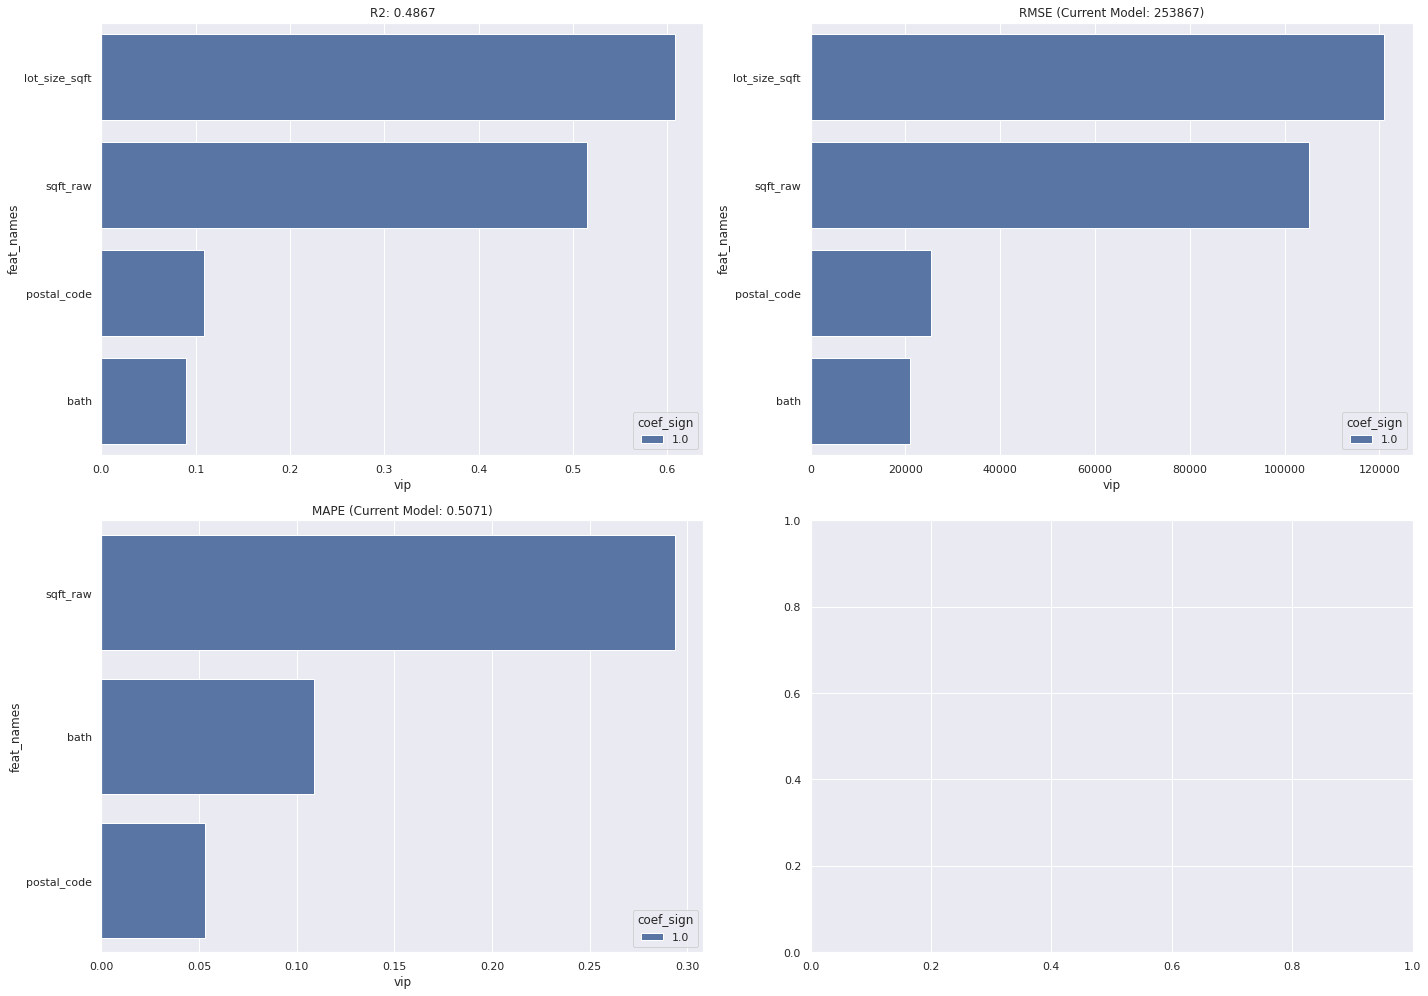

In [ ]:
if show_importances:
    # The permutation feature importance is the decrease in a model score when a single feature value is randomly shuffled

    fig, ax = plt.subplots(2,2)

    sns.barplot(
        data=coef_info[ coef_info['metric'] == 'r2'], 
        x="vip", 
        y='feat_names',
        hue='coef_sign', 
        ax=ax[0,0]
    ).set_title(f'R2: {r2:.4f}')

    sns.barplot(
        data=coef_info[ coef_info['metric'] == 'neg_root_mean_squared_error'], 
        x="vip", 
        y='feat_names',
        hue="coef_sign", 
        ax=ax[0,1]
    ).set_title(f'RMSE (Current Model: {rmse:.0f})')

    sns.barplot(
        data=coef_info[ coef_info['metric'] == 'neg_mean_absolute_percentage_error'], 
        x="vip", 
        y='feat_names',
        hue="coef_sign", 
        ax=ax[1,0]
    ).set_title(f'MAPE (Current Model: {mape:.4f})')

    fig.set_size_inches(20, 14)
    fig.show()

## Questions

**Are the enough data points to perform a prediction in the geographical area of interest?**

*Yes, we have enough data to begin, and can collect more as needed.*

**What data cleaning tasks are necessary?**

*Data conversions, replacing NANs and strings, and strategically dropping some categories/columns.  Dropping foward looking values is important to avoiding leakage.*

**Is missing data a problem for any particular columns?**

*Yes, key missing values for sqft and bathrooms pose a risk.  Will need to be cautious with filling those.*

**Do any basic patterns emerge that increase/decrease trust in the dataset?**

*None that cannot be handled with data cleaning.*